In [1]:
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import brevitas.nn as qnn

## Paths and some params

In [8]:
project_path = Path.cwd().parents[1]
mnist_path = project_path/'data/mnist'
weight_dir = project_path/'quant_he_code/weights/'

input_bit_width = 2
weight_bit_width = 4
weight_file = f"quant_hcnn_{input_bit_width}bits_mnist_plain_{weight_bit_width}bits_weights.pth"
weight_file_path = weight_dir / weight_file
weight_file_path

PosixPath('/home/dk/Desktop/projects/PocketHHE/quant_he_code/weights/quant_hcnn_2bits_mnist_plain_4bits_weights.pth')

## Load the test dataset

In [11]:
def mnist_processing(option: int):
    if option == 0:
        transform = transforms.Compose([
            ToTensor(),
            lambda x: (x*4).int(),
            lambda x: x.float()/4,
        ])
    elif option == 2:
        transform = transforms.Compose([
            ToTensor(),
            lambda x: (x * 3).int().float(),
        ])
    else:
        raise NotImplementedError
    
    test_dataset = MNIST(root=mnist_path, train=False, transform=transform)
    
    return test_dataset

test_dataset = mnist_processing(option=input_bit_width)
test_loader = DataLoader(test_dataset, batch_size=64, pin_memory=True)

torch.Size([28, 28])
Processed MNIST data unique values = tensor([0., 1., 2., 3.])


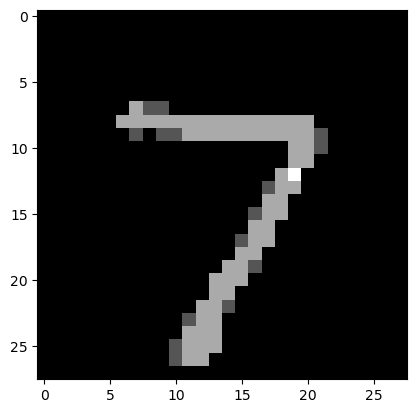

In [6]:
scale_factor_input = 1 / 3
im = test_dataset[0][0][0]
print(im.shape)
print(f"Processed MNIST data unique values = {im.unique()}")
plt.imshow(im, cmap='gray')

## Define and load the network

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))

In [9]:
class MNISTConvQuantModel(ImageClassificationBase):
    """
    2 conv layers + 2 square activations + 1 linear layer
    """
    def __init__(self):
        super().__init__()
        self.conv1 = qnn.QuantConv2d(in_channels=1, out_channels=5, kernel_size=5, 
                                     stride=(2, 2), padding=0, bias=False, 
                                     weight_bit_width=weight_bit_width, 
                                     return_quant_tensor=True)
        self.conv2 = qnn.QuantConv2d(in_channels=5, out_channels=50, kernel_size=5, 
                                     stride=(2, 2), padding=0, bias=False, 
                                     weight_bit_width=weight_bit_width)
        self.fc1 = qnn.QuantLinear(in_features=800, out_features=10, bias=False, 
                                   weight_bit_width=weight_bit_width, 
                                   return_quant_tensor=True)

    def forward(self, xb):
        out = self.conv1(xb)
        out = out * out  # first square
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = out * out  # second square
        out = self.fc1(out)

        return out

In [10]:
model = MNISTConvQuantModel()
model.load_state_dict(
    torch.load(weight_file_path, 
    map_location=torch.device('cpu'))
)

<All keys matched successfully>

## Do inference on test dataset

In [17]:
for x, y in test_loader:
    print(x.unique())
    print(y.unique())
    break

tensor([0., 1., 2., 3.])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [12]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

acc = evaluate(model, test_loader)['val_acc']
print(f"test accuracy with trained {weight_bit_width}-bit weights = {acc}")

/home/dk/miniconda3/envs/pockethhe/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_367082/3874017255.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  _, preds = torch.max(outputs, dim=1)


test accuracy with trained 4-bit weights = 0.9871616363525391


## Inspecting the model

In [19]:
model.conv1.int_weight()

tensor([[[[-1,  2,  6,  1, -5],
          [ 1,  0, -3,  4, -1],
          [ 0,  2, -1,  5,  7],
          [-1,  7,  4,  0,  2],
          [ 4,  3, -3, -5, -4]]],


        [[[-1,  1, -3, -1,  0],
          [-3,  5,  4,  5,  3],
          [-5,  4,  4,  3, -4],
          [-6, -7, -7, -1,  1],
          [-2,  2, -3, -5,  1]]],


        [[[-1, -7, -6, -2,  2],
          [ 4,  0, -5, -7,  2],
          [ 6,  6,  2, -6, -2],
          [ 2,  6,  4, -3, -2],
          [-3,  2,  3, -2, -1]]],


        [[[-2,  0, -3,  4,  3],
          [-6, -2, -1,  7, -2],
          [-6,  0,  4,  6, -4],
          [-6, -1,  3,  6, -2],
          [-5,  0, -1,  3,  2]]],


        [[[-1,  1,  2,  1,  0],
          [ 2,  2, -4, -3,  2],
          [-5, -6, -5,  0,  7],
          [-7, -3,  3,  7,  1],
          [ 4,  6,  7,  2, -3]]]], dtype=torch.int8)

In [20]:
model.conv1.quant_weight() / model.conv1.quant_weight().scale

QuantTensor(value=tensor([[[[-1.,  2.,  6.,  1., -5.],
          [ 1., -0., -3.,  4., -1.],
          [ 0.,  2., -1.,  5.,  7.],
          [-1.,  7.,  4., -0.,  2.],
          [ 4.,  3., -3., -5., -4.]]],


        [[[-1.,  1., -3., -1.,  0.],
          [-3.,  5.,  4.,  5.,  3.],
          [-5.,  4.,  4.,  3., -4.],
          [-6., -7., -7., -1.,  1.],
          [-2.,  2., -3., -5.,  1.]]],


        [[[-1., -7., -6., -2.,  2.],
          [ 4., -0., -5., -7.,  2.],
          [ 6.,  6.,  2., -6., -2.],
          [ 2.,  6.,  4., -3., -2.],
          [-3.,  2.,  3., -2., -1.]]],


        [[[-2.,  0., -3.,  4.,  3.],
          [-6., -2., -1.,  7., -2.],
          [-6.,  0.,  4.,  6., -4.],
          [-6., -1.,  3.,  6., -2.],
          [-5.,  0., -1.,  3.,  2.]]],


        [[[-1.,  1.,  2.,  1., -0.],
          [ 2.,  2., -4., -3.,  2.],
          [-5., -6., -5., -0.,  7.],
          [-7., -3.,  3.,  7.,  1.],
          [ 4.,  6.,  7.,  2., -3.]]]], grad_fn=<DivBackward0>), scale=None, z